# Personalized News

In [ ]:
import sys
!{sys.executable} -m pip install pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from wordcloud import WordCloud, STOPWORDS
import tensorflow
import re
import string
import nltk
import os
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rmisra/news-category-dataset
!unzip /content/news-category-dataset.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 94% 25.0M/26.5M [00:00<00:00, 127MB/s] 
100% 26.5M/26.5M [00:00<00:00, 116MB/s]
Archive:  /content/news-category-dataset.zip
  inflating: News_Category_Dataset_v3.json  


### Data Exploration

In [ ]:
import json
data=[]
with open('News_Category_Dataset_v3.json', 'r') as f:
    for line in f:
        content = json.loads(line)
        data.append(content)
df = pd.DataFrame(data=data)
df.head()



,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


**Data Description:**

**link:** It is the link to the original article

**headline:** This is the headline of the news article published

**category:** The category in which the news article belongs to

**short_description:** Abstract of the news article

**authors:** The writer/author of the news article

**date:** The publication date of the news article

In [ ]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(209527, 6)
Unique categories: 42
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   link               209527 non-null  object
 1   headline           209527 non-null  object
 2   category           209527 non-null  object
 3   short_description  209527 non-null  object
 4   authors            209527 non-null  object
 5   date               209527 non-null  object
dtypes: object(6)
memory usage: 9.6+ MB


In [ ]:
# general descrption of dataset
df.describe()

,link,headline,category,short_description,authors,date
count,209527,209527,209527,209527,209527,209527
unique,209486,207996,42,187022,29169,3890
top,https://www.huffingtonpost.comhttps://www.wash...,Sunday Roundup,POLITICS,,,2014-03-25
freq,2,90,35602,19712,37418,100


In [ ]:
!pip install pandas_profiling


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# produce pandas profiling report
df.profile_report()

AttributeError: ignored

**Key Findings:**

1. Dataset has **42** distinct categories of news article.
2. **'Politics'** is the most common category of news in our dataset.
3. The dataset contains **29169** unique authors.
4. Maximum length of the headline is **320** while median length of the headline is **143**.
5. Maximum length of the description is **1472** while median length of the headline is around **114**.

In [ ]:
# Checking for missing values in the dataset
print(df.isna().sum())
print('There are no null values in the dataset')

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64
There are no null values in the dataset


In [ ]:
df[df['short_description'].apply(lambda x: len(x)==0)].shape

(19712, 6)

The short desctiption has **19712** rows which are empty.

So we drop these rows.

In [ ]:
df = df[~df['short_description'].apply(lambda x: len(x)==0)]

In [ ]:
# drop columns like authors, links and date as they are irrelevent to our problem.
df = df.drop(columns=['authors','link','date'])
df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


### Visualization

In [ ]:
#Get count for each category
category_count = df['category'].value_counts()
print(category_count)
print(f'There are {len(category_count)} categories of news')

POLITICS          32441
WELLNESS          17943
ENTERTAINMENT     14774
STYLE & BEAUTY     9802
TRAVEL             9421
PARENTING          8790
FOOD & DRINK       6331
QUEER VOICES       5603
HEALTHY LIVING     5265
BUSINESS           5132
COMEDY             4642
SPORTS             4414
HOME & LIVING      4317
BLACK VOICES       4177
THE WORLDPOST      3664
WEDDINGS           3653
PARENTS            3556
DIVORCE            3426
WORLD NEWS         3297
WOMEN              3184
IMPACT             3086
CRIME              2832
MEDIA              2404
WEIRD NEWS         2316
TECH               2103
GREEN              2046
TASTE              1940
RELIGION           1879
SCIENCE            1803
MONEY              1755
STYLE              1567
ENVIRONMENT        1442
U.S. NEWS          1377
ARTS & CULTURE     1339
WORLDPOST          1242
CULTURE & ARTS     1063
FIFTY              1042
GOOD NEWS          1039
LATINO VOICES      1022
COLLEGE             921
EDUCATION           902
ARTS            

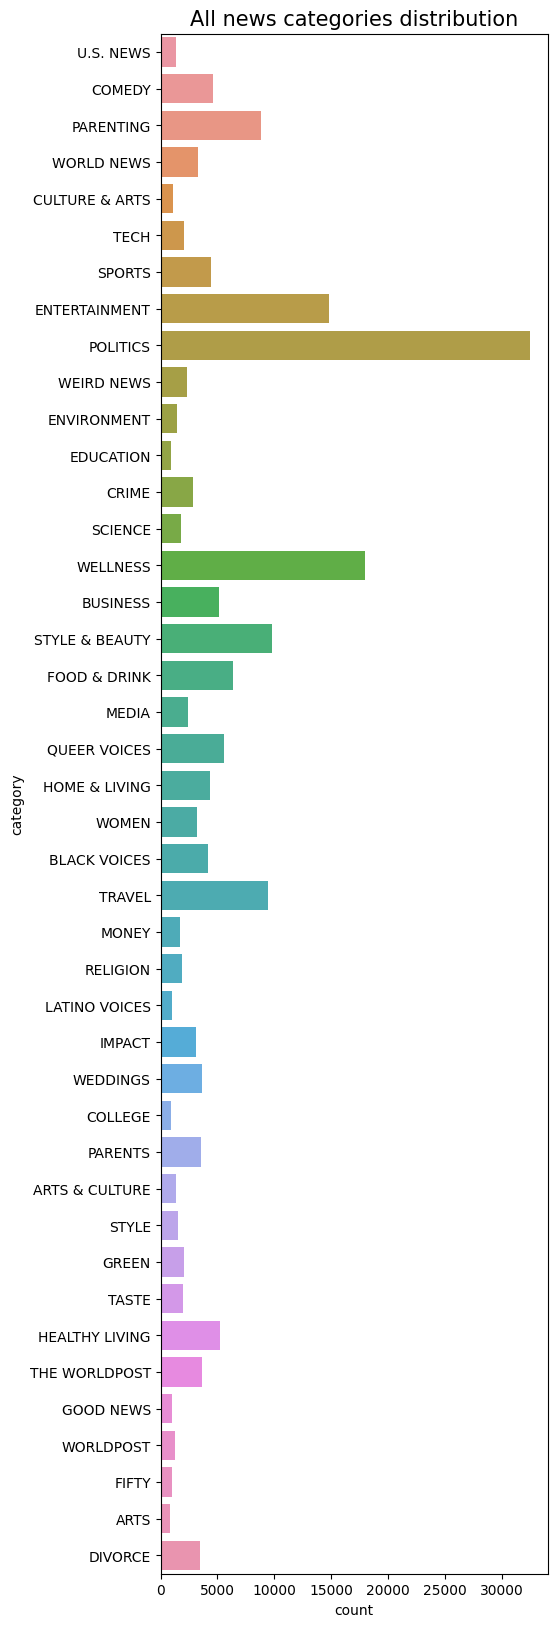

In [ ]:
#Plot horizontal category distribution
plt.figure(figsize = [5, 20])
sns.countplot(y=df["category"], orient = 'h')
plt.title("All news categories distribution", fontsize = 15)
plt.show()

Text(0, 0.5, 'Number of articles')

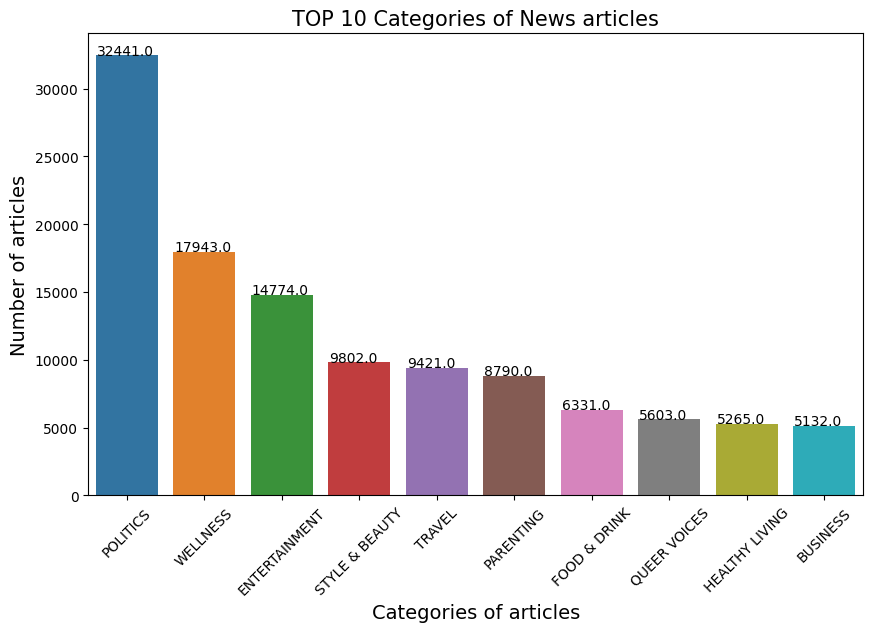

In [ ]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(df['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)

# Visualize top 10 categories and proportion of each categories in dataset
plt.figure(figsize=(10,6))
ax = sns.barplot(x = np.array(cat_df.news_classes)[:10], y = np.array(cat_df.numcat)[:10])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))
plt.title("TOP 10 Categories of News articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)

Text(0.5, 1.0, 'Pie Chart of TOP 20 categories of news articles')

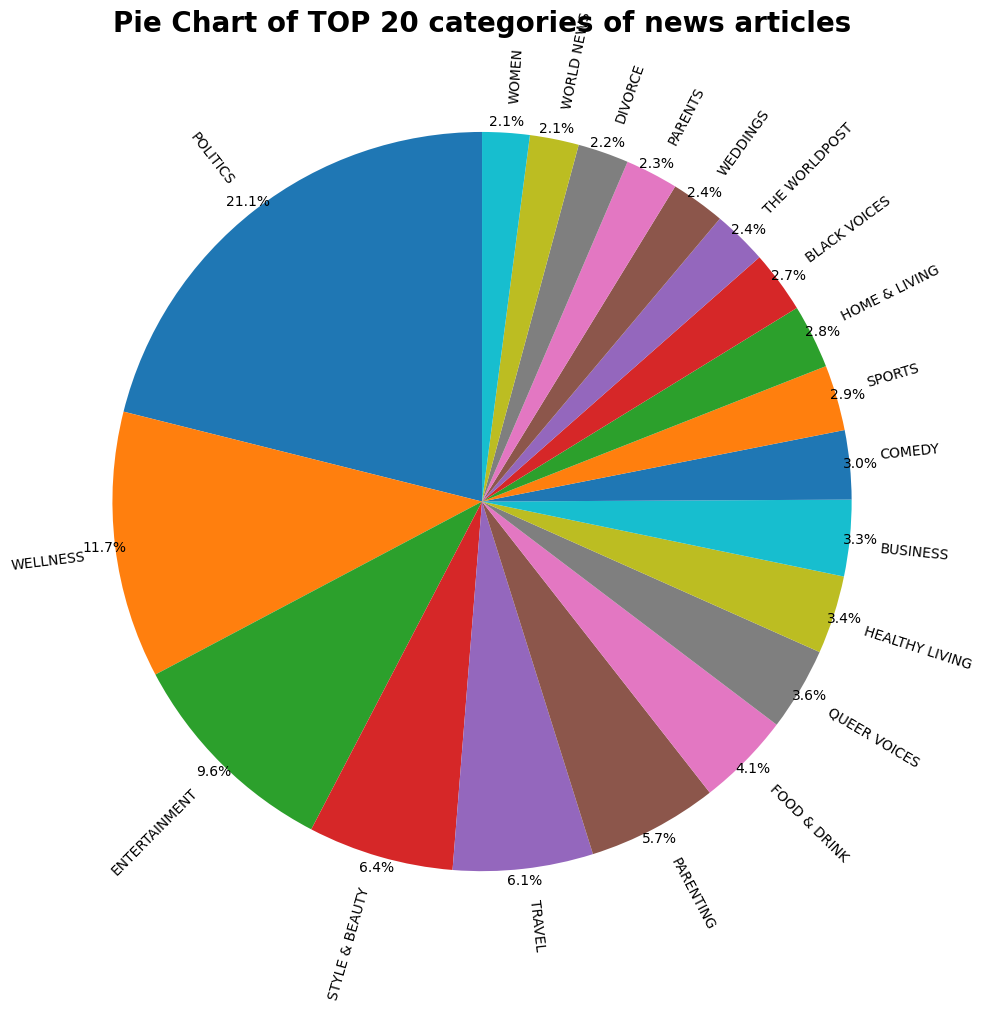

In [ ]:
# plot the pie chart of top 20 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['numcat'][:20],
            labels=cat_df['news_classes'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of TOP 20 categories of news articles", size=20, weight='bold')

In [ ]:
# create final dataframe of combined headline and short_description
final_df = df.copy()
final_df['length_of_news'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

,category,length_of_news,len_news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,230
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",248
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,133
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,215
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,233


In [ ]:
# maximum length of news in each category
lenmax_df = final_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

,category,len_news
24,POLITICS,1486
41,WORLDPOST,1424
4,COLLEGE,1225
16,HEALTHY LIVING,1073
38,WELLNESS,1036


In [ ]:
# minimum lenght of news in each category
lenmin_df = final_df.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df.head()

,category,len_news
0,ARTS,89
35,U.S. NEWS,73
8,DIVORCE,66
12,FIFTY,62
6,CRIME,60


Text(0.5, 1.0, 'Min length of top 10 news categories')

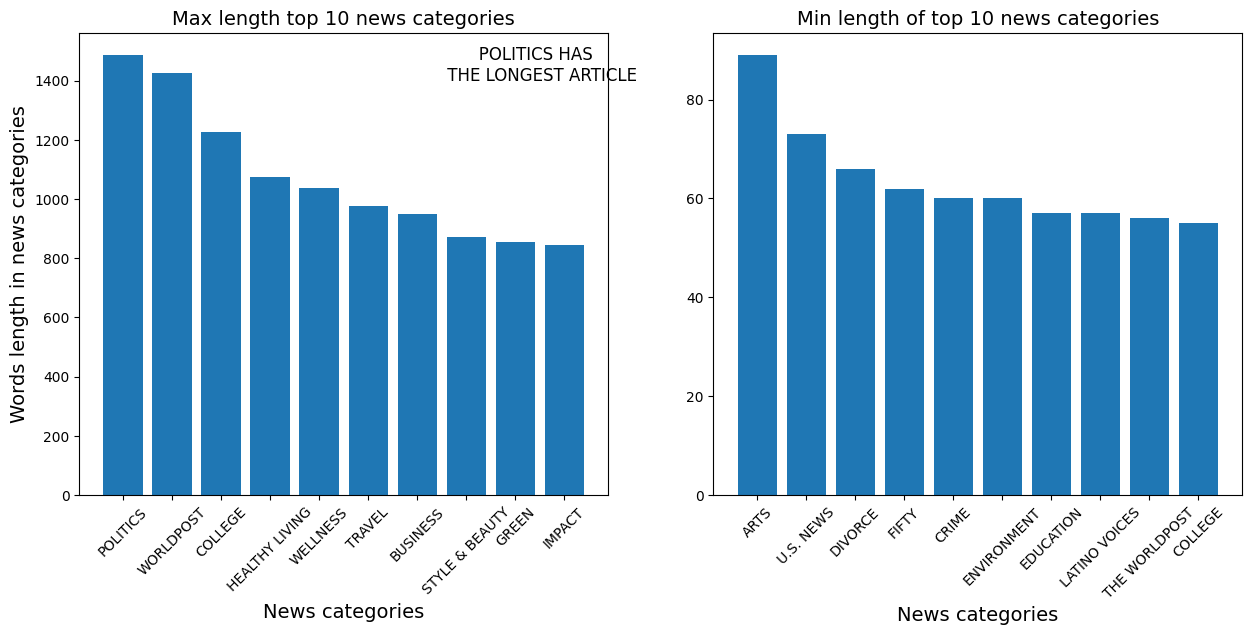

In [ ]:
# plot the bar plots of max and min length of news articles
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['category'][:10],lenmax_df['len_news'][:10])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.text(6.5,1400, '''       POLITICS HAS 
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df['category'][:10], lenmin_df['len_news'][:10])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of top 10 news categories", size=14)

**Key Findings:**

1. From all the categories of news POLITICS has the most number of articles as well as length of characters in the article (headlines and short-description)
2. After 'POLITICS' category, 'WORLDPOST', 'COLLEGE', 'HEALTHY LIVING','WELLNESS' categories are in top 5 most length of articles
3. 'POLITICS', 'WELLNESS' and 'ENTERTAINTMENT' are top 3 categories having most number of articles in out dataset.

#### Creating WordCloud

(-0.5, 1599.5, 599.5, -0.5)

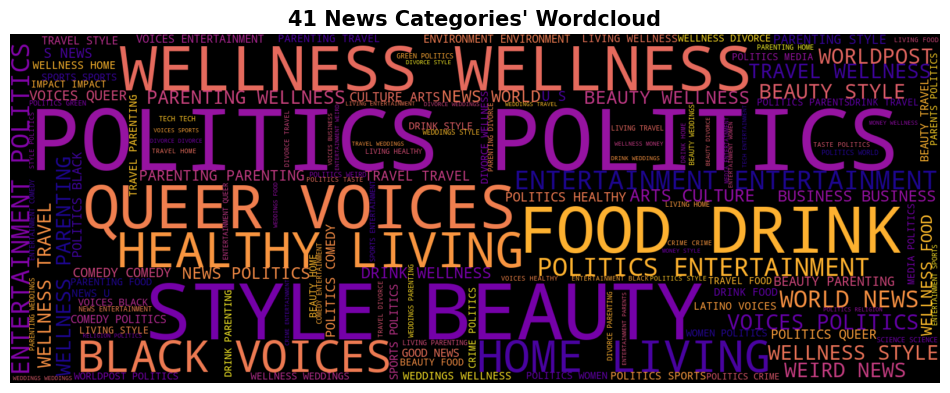

In [ ]:


# wordcloud of categories of news articles in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(final_df.category))

plt.title("41 News Categories' Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

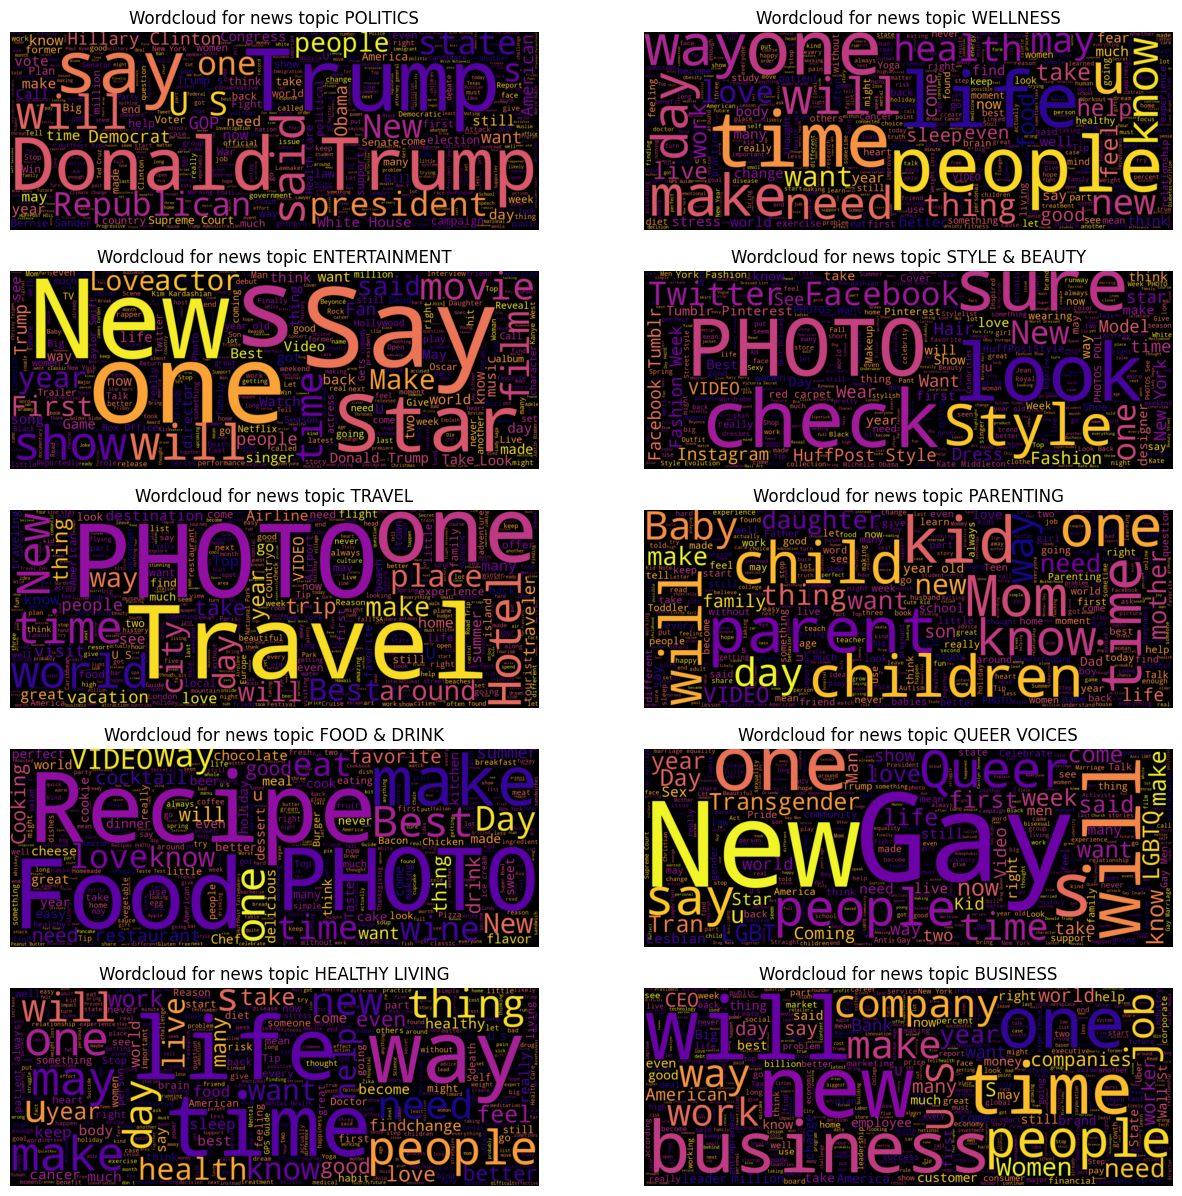

In [ ]:
# create new dataframe of category and length of each news articles in that categories
ndf = final_df.copy()
ndf.drop('len_news', inplace=True, axis=1)

# list of top 10  categories in out dataset
categories = cat_df['news_classes'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = ndf[ndf['category'] == i]
    cat_array = cat_ndf['length_of_news'].values  # array of news articles text in each category
    articles_list.append(cat_array)
    
# create a wordcloud instance
wc1 = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

In [ ]:
# only top 15 train data counts
top_categories = list(df["category"].value_counts().nlargest(15).keys())
print(top_categories)

['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK', 'BUSINESS', 'COMEDY', 'SPORTS', 'BLACK VOICES', 'HOME & LIVING', 'PARENTS']


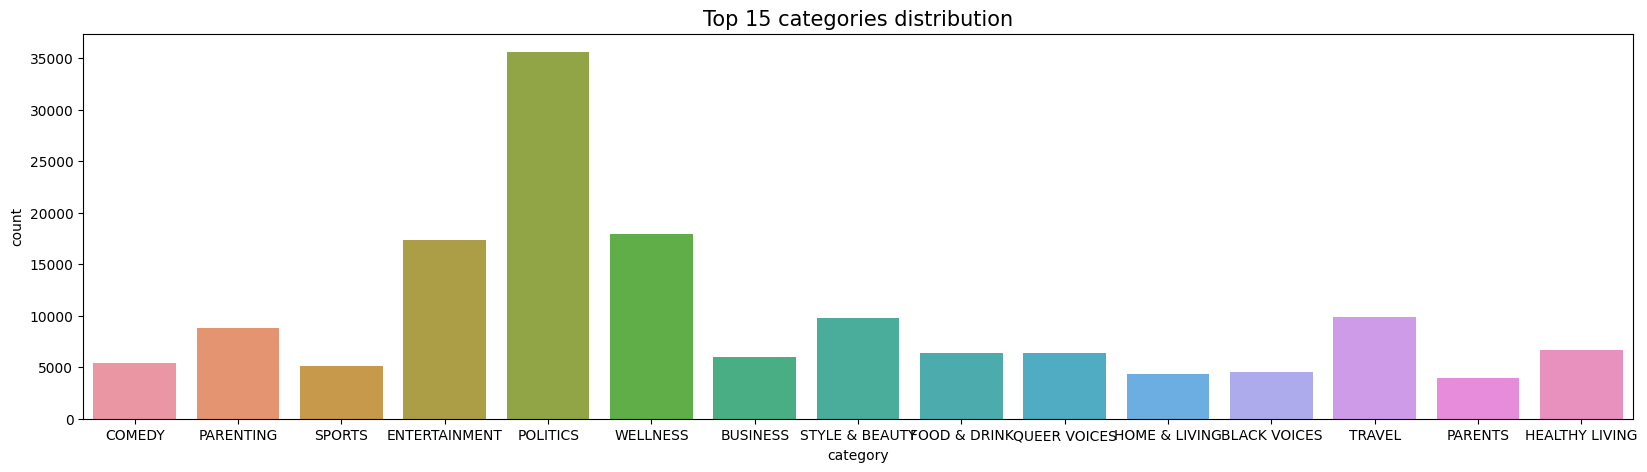

In [ ]:

dataset_top = df[df['category'].isin(top_categories)]
plt.figure(figsize = [20, 5])
sns.countplot(x=dataset_top["category"])
plt.title("Top 15 categories distribution", fontsize = 15)
plt.show()

#### Up-Sampleing the data for uniformity

In [ ]:
# Upsampling the data
SEED = 42
df_list = []
#Get news in top 15 categories
for i in top_categories:
    df_list.append(pd.DataFrame(dataset_top[dataset_top["category"]==i]))
for i in range(len(df_list)):
    df_list[i] = pd.DataFrame(df_list[i][df_list[i]["short_description"]!=""])
for i in range(len(df_list)):
    df_list[i] = df_list[i].sample(df_list[0].shape[0], replace=True, random_state=SEED)
df_upsample = pd.concat(df_list)
print(df_upsample.shape)

(486615, 6)


In [ ]:
#Check 5 samples of short description
df_list[0].short_description.iloc[0:5].to_list()

['Ambivalence about a Trump-Cruz battle pushes many Republican fundraisers away from the presidential contest.',
 "The plan is very hazy, but it's different than what other Republicans have proposed.",
 "MeidasTouch's #GOPBetrayedAmerica spot calls out Republican opposition to a commission to investigate the Jan. 6 insurrection.",
 '"The risks of fracking to our health and to our environment are real," state Attorney General Xavier Becerra says.',
 'Sen. Bernie Sanders claims that in the United States, “almost all of the wealth rests in the hands of the few.” He exaggerates']

### Data Cleaning

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('words')


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

In [ ]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#Clean the text
df_upsample["text"] = df_upsample["headline"] + " " + df_upsample["short_description"]
df_upsample['text'] = df_upsample['text'].map(lambda x: clean_text(x))
X, y = df_upsample['text'], df_upsample["category"]

In [ ]:
#Text after cleaning
print(X.iloc[0])

sheldon adelson top gop donor retreat sideline ambivalence trumpcruz battle push many republican fundraiser away presidential contest


In [ ]:
#Data size after upsampling
print(y.value_counts())

POLITICS          32441
WELLNESS          32441
ENTERTAINMENT     32441
STYLE & BEAUTY    32441
TRAVEL            32441
PARENTING         32441
FOOD & DRINK      32441
QUEER VOICES      32441
HEALTHY LIVING    32441
BUSINESS          32441
COMEDY            32441
SPORTS            32441
HOME & LIVING     32441
BLACK VOICES      32441
THE WORLDPOST     32441
Name: category, dtype: int64


In [ ]:
#Split data into training data and testing data
# split the data
X_train, X_test, y_train, y_test = train_test_split(df_upsample['text'], df_upsample['category'], test_size=0.2, stratify=df_upsample['category'])
le = preprocessing.LabelEncoder()
le.fit(top_categories)
# category to label
y_train_label = le.transform(y_train)
y_test_label = le.transform(y_test)
#Use tf-idf vectorizer to fit news
tf_idf_vectorizer = TfidfVectorizer()
X_train_t = tf_idf_vectorizer.fit_transform(X_train)
X_test_t = tf_idf_vectorizer.transform(X_test)
print(X_train.shape, X_train_t.shape)

(389292,) (389292, 77561)


# **LOGISTIC REGRESSION AND NAIVE BAYES**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load data

# Create a logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Fit the model to the training data
model.fit(X_train_t, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_t)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.865437769078224


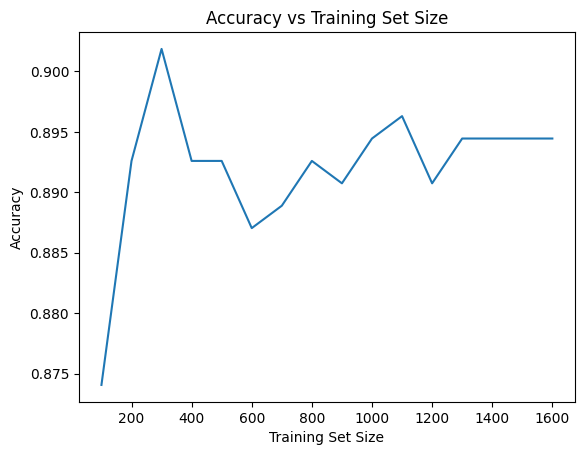

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model=MultinomialNB()
model.fit(X_train_t,y_train)
y_pred = model.predict(X_test_t)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.832691141867801
